In [1]:
from source_data import Requests
from utils import format_time
from ride_share import DATES,DAY_NAMES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns
import os

In [2]:
# get the requests and measure volume per window
requests = Requests().read_requests()
requests.head()

,time,from_node,to_node,window,day,hour,latest_pickup
0,0,1167,1956,0,0,0,120
1,0,1669,1243,0,0,0,120
2,0,1609,1632,0,0,0,120
3,0,1092,910,0,0,0,120
4,0,1278,867,0,0,0,120


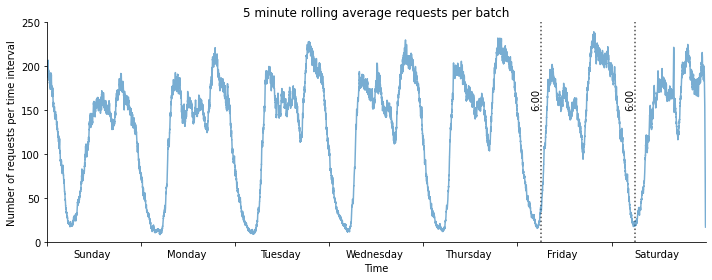

In [3]:
# summarise the requests by hour
numreqs_by_window = requests.groupby(['window']).agg('count')['time'].rename("num_requests")

# create a readable axis
# ticks are windows
xticks = range(0,int(60*60*24*7/30))
skippage = 1440*2
times_seconds = [ 30*w+30 for w in xticks[::skippage] ]

# labels should reflect date-times
# xlabels = [f"{format_time((t//3600)%24,t)}, {DAY_NAMES[t//(3600*24)]}" for t in times_seconds]
xlabels = [DAY_NAMES[t//(3600*24)] for t in times_seconds]

# count the number of request picked up in each window
fig,ax = plt.subplots(figsize=[10,4])
numreqs_by_window.rolling(10).mean().plot(alpha=0.6,ax=ax)

# try to stick a line on Friday morning to Saturday mornging
day_offset = 120*6+1
start = 5*24*120+day_offset
end = 6*24*120+day_offset
v_lines = [start,
           end]
ax.vlines(v_lines,
          ymin=[0,0],
          ymax=[300,300],
          ls=":",
          color='black',
          alpha=0.7)

ax.set_title("5 minute rolling average requests per batch")
ax.set_ylabel("Number of requests per time interval")
ax.set_xlabel("Time")

# Show days as tick labels
ax.set_xticks(xticks[::skippage])
ax.set_xticklabels(xlabels)

# Create offset transform by 5 points in x direction
dx = 45/72;dy=0
offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)

# apply offset transform to all x ticklabels.
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
    
# draw the times
y_pos = 150
ax.text(start,y_pos,"6:00",ha="right",va="bottom",rotation=90)
ax.text(end,y_pos,"6:00",ha="right",va="bottom",rotation=90)

ax.set_ylim([0,250])
ax.set_xlim([0,20160])
sns.despine()
fig.tight_layout()
plt.savefig(r"results/count_allrequests.jpg")

In [4]:
# get the number of requests in the period
original = r"datasets/GIS_analysis/_old/yellow_tripdata_2013-05.csv"
to_check = []

# read in chunks and only keep data from this week
usecols = ['pickup_datetime','dropoff_datetime']
target_start = pd.to_datetime('2013-05-10 00:05:00')
target_end = pd.to_datetime('2013-05-11 00:05:00')
for chunk in pd.read_csv(original,usecols=usecols,parse_dates=usecols,chunksize=50000):
    
    check = chunk[(chunk[usecols[1]]>target_start)&
                 (chunk[usecols[0]]<target_end)]
    
    if not check.empty:
        to_check.append(check)
    
to_check = pd.concat(to_check,ignore_index=True)
to_check.head()

,pickup_datetime,dropoff_datetime
0,2013-05-10 07:51:00,2013-05-10 07:58:00
1,2013-05-10 13:48:00,2013-05-10 13:59:00
2,2013-05-10 06:37:00,2013-05-10 06:50:00
3,2013-05-10 04:07:00,2013-05-10 04:25:00
4,2013-05-10 16:11:00,2013-05-10 16:21:00


In [5]:
# now do a sliding count at 5s intervals active trips
time_index = [
    target_start + pd.to_timedelta(f"{d} seconds") for d in np.arange(0,24*3600,5)
]

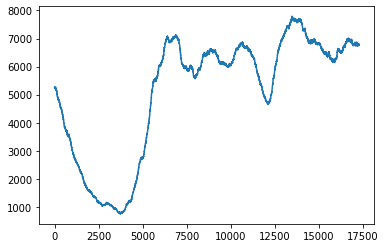

In [6]:
counts = []
for time_check in time_index:
    
    counts.append(
        to_check[(to_check[usecols[0]]<=time_check)&(to_check[usecols[1]]>time_check)].shape[0]
    )

plt.plot(counts)

In [7]:
print(max(counts))

7793


In [8]:
7790*2.7/3.5


6009.428571428572

In [11]:
7793/(13605*0.8)

0.7160051451672179

As of March 2014 there were 13,605 yellow cabs registered in NYC, from the dataset analysed over this peak period, there were up to 7800 in operation at any one time. Assuming 80% availability, this suggests a maximum utilisation of ~70%.

We only look at a fraction of the requests, ~77% were filtered out based on the data cleaning methods required to undertake the analysis over the same period. We apply linear scaling for comparison with the existing fleet.

In [10]:
3000/0.77

3896.103896103896